In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import gc
from utils import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
payments = pd.read_csv('D:/Data Preparation final project group 2/Data/dseb63_installments_payments.csv')
train = pd.read_csv('D:/Data Preparation final project group 2/Data/dseb63_application_train.csv')
pre = pd.read_csv('D:/Data Preparation final project group 2/Data/dseb63_previous_application.csv')

SK_ID_PREV                   0
NUM_INSTALMENT_VERSION       0
NUM_INSTALMENT_NUMBER        0
DAYS_INSTALMENT              0
DAYS_ENTRY_PAYMENT        1639
AMT_INSTALMENT               1
AMT_PAYMENT               1639
SK_ID_CURR                   1
dtype: int64


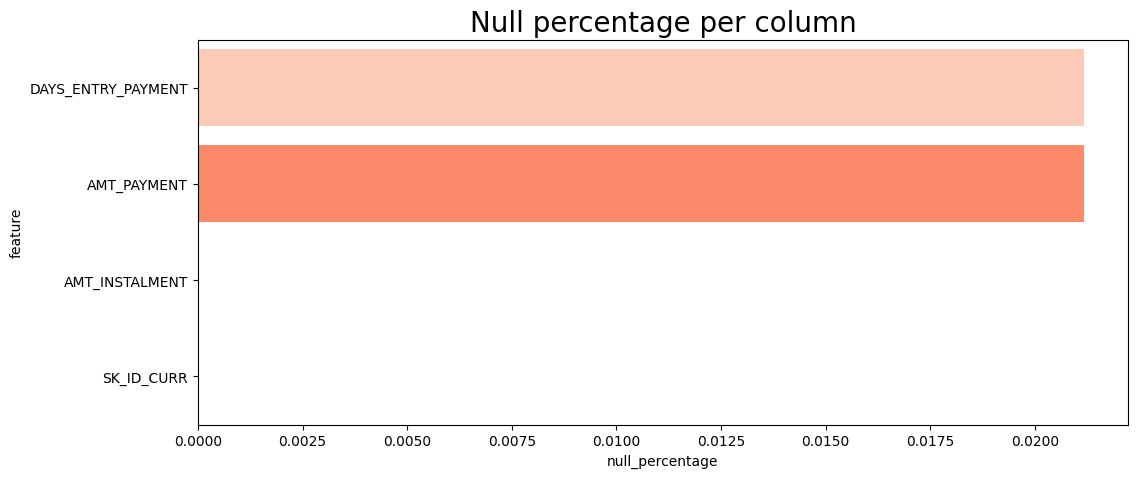

In [3]:
payments_statics = StatisticAnalysis(payments)
payments_statics.check_null()

In [4]:
# Fill null value in installment payment:
# % Giá trị null không cao --> 
payments['DAYS_ENTRY_PAYMENT'] = payments['DAYS_ENTRY_PAYMENT'].fillna(0)
payments['AMT_PAYMENT'] = payments['AMT_PAYMENT'].fillna(0)
payments['AMT_INSTALMENT'] = payments['AMT_INSTALMENT'].fillna(0)
payments.isnull().sum(axis=0)

SK_ID_PREV                0
NUM_INSTALMENT_VERSION    0
NUM_INSTALMENT_NUMBER     0
DAYS_INSTALMENT           0
DAYS_ENTRY_PAYMENT        0
AMT_INSTALMENT            0
AMT_PAYMENT               0
SK_ID_CURR                1
dtype: int64

In [5]:
#join 2 table installment payment and application_train qua previous application
#join train voi previous app
train_pre = pd.merge(train, pre, on = 'SK_ID_CURR')
train_pre_copy = train_pre[['TARGET', 'SK_ID_PREV']]
pay = pd.merge(train_pre_copy, payments, on='SK_ID_PREV')

In [6]:
pay = do_sum(pay, ['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'], 'AMT_PAYMENT', 'AMT_PAYMENT_GROUPED')
pay['PAYMENT_DIFFERENCE'] = pay['AMT_INSTALMENT'] - pay['AMT_PAYMENT_GROUPED']
pay['PAYMENT_RATIO'] = pay['AMT_INSTALMENT'] / pay['AMT_PAYMENT_GROUPED']
pay['PAID_OVER_AMOUNT'] = pay['AMT_PAYMENT'] - pay['AMT_INSTALMENT']
pay['PAID_OVER'] = (pay['PAID_OVER_AMOUNT'] > 0).astype(int)
# Payment Entry: Days past due and Days before due
pay['DPD'] = pay['DAYS_ENTRY_PAYMENT'] - pay['DAYS_INSTALMENT']
pay['DPD'] = pay['DPD'].apply(lambda x: 0 if x <= 0 else x)
pay['DBD'] = pay['DAYS_INSTALMENT'] - pay['DAYS_ENTRY_PAYMENT']
pay['DBD'] = pay['DBD'].apply(lambda x: 0 if x <= 0 else x)
# Flag late payment
pay['LATE_PAYMENT'] = pay['DBD'].apply(lambda x: 1 if x > 0 else 0)
# Percentage of payments that were late
pay['INSTALMENT_PAYMENT_RATIO'] = pay['AMT_PAYMENT'] / pay['AMT_INSTALMENT']
pay['LATE_PAYMENT_RATIO'] = pay.apply(lambda x: x['INSTALMENT_PAYMENT_RATIO'] if x['LATE_PAYMENT'] == 1 else 0, axis=1)
# Flag late payments that have a significant amount
pay['SIGNIFICANT_LATE_PAYMENT'] = pay['LATE_PAYMENT_RATIO'].apply(lambda x: 1 if x > 0.05 else 0)
# Flag k threshold late payments
pay['DPD_7'] = pay['DPD'].apply(lambda x: 1 if x >= 7 else 0)
pay['DPD_15'] = pay['DPD'].apply(lambda x: 1 if x >= 15 else 0)
pay['INS_IS_DPD_UNDER_120'] = pay['DPD'].apply(lambda x: 1 if (x > 0) & (x < 120) else 0)
pay['INS_IS_DPD_OVER_120'] = pay['DPD'].apply(lambda x: 1 if (x >= 120) else 0)

In [7]:
pay_default = pay[pay['TARGET']==1]
pay_non_default = pay[pay['TARGET']==0]

# Giải thích feature mới và trực quan hóa features:

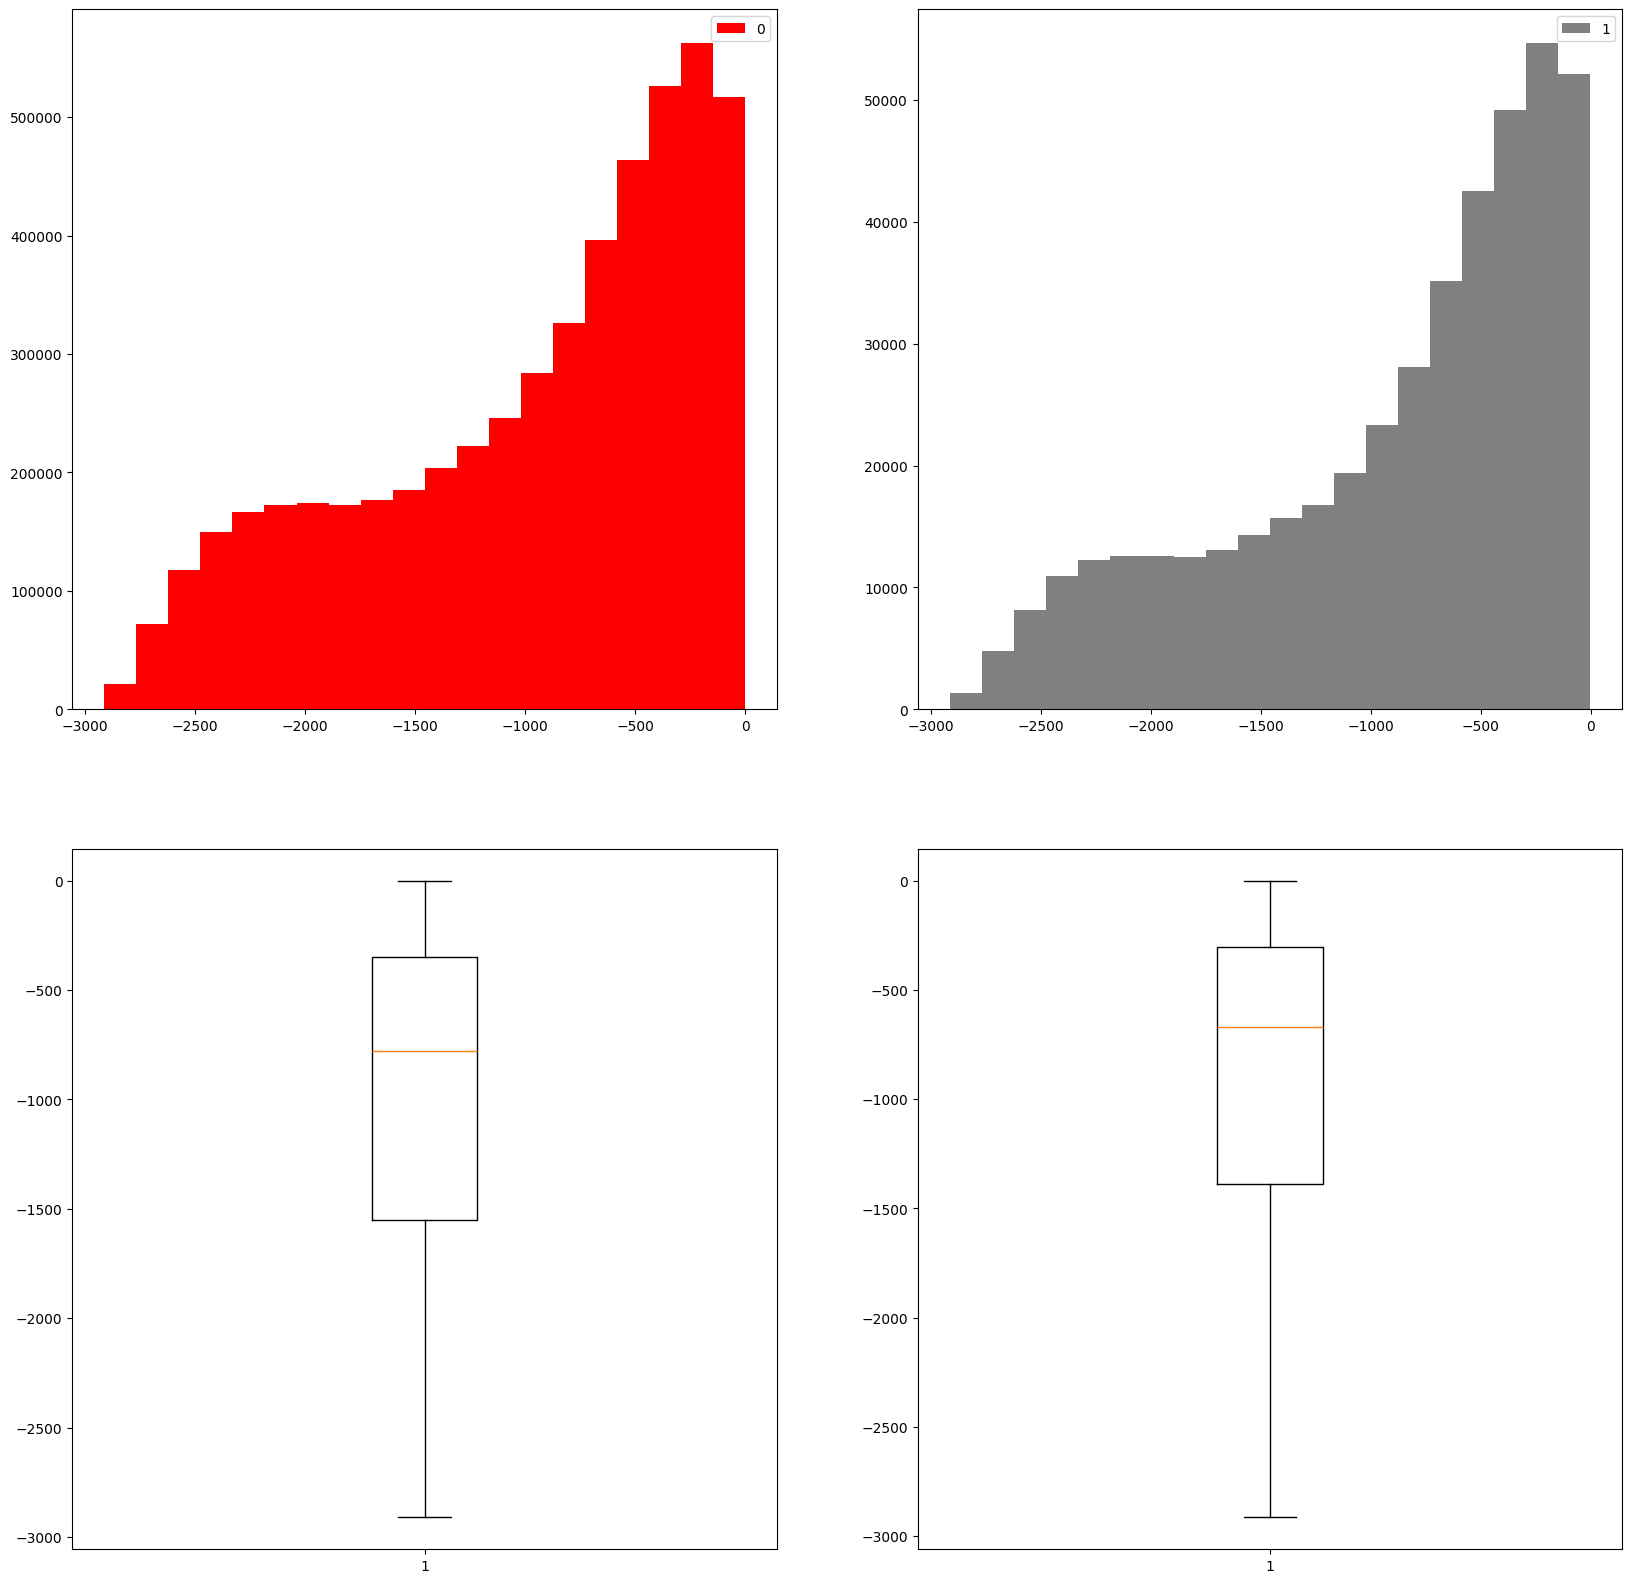

In [8]:
#DAYS_INSTALMENT - Histogram
fig,ax = plt.subplots(2,2,figsize = (20,20))
a1 = pay[pay['TARGET'] == 0][['DAYS_INSTALMENT']]
ax[0][0].hist(a1,bins = 20,label = '0', color = 'red')
ax[0][0].legend()
ax[1][0].boxplot(a1)
a2 = pay[pay['TARGET'] == 1][['DAYS_INSTALMENT']]
ax[0][1].hist(a2,bins = 20,label = '1', color = 'grey')
ax[0][1].legend()
ax[1][1].boxplot(a2);

Distribution of DAYS_INSTALMENT on 2 classes are quite similar

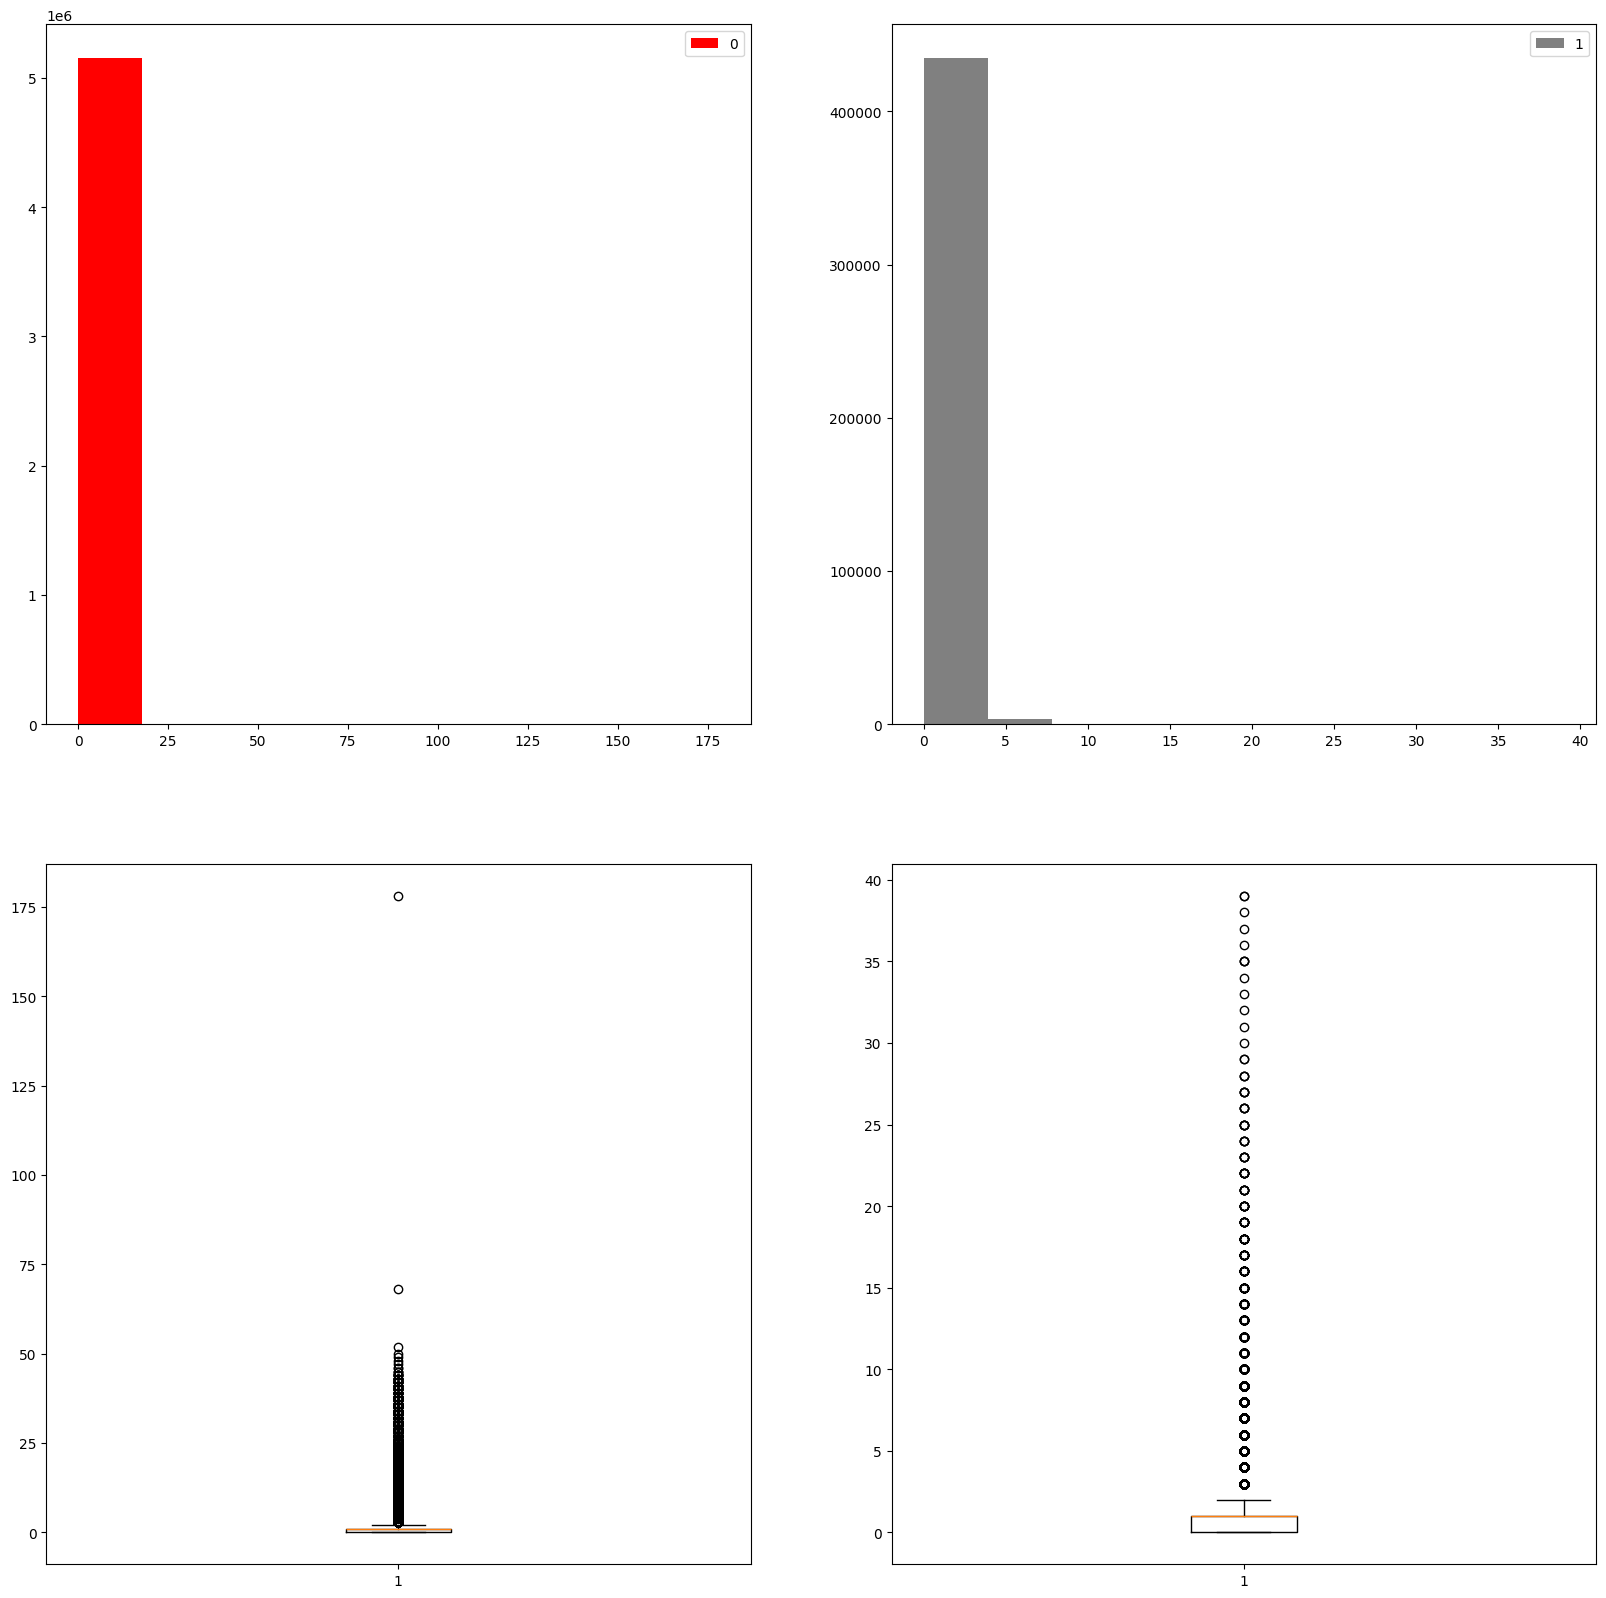

In [9]:
#NUM_INSTALMENT_VERSION - Histogram
fig,ax = plt.subplots(2,2,figsize = (20,20))
a1 = pay[pay['TARGET'] == 0][['NUM_INSTALMENT_VERSION']]
ax[0][0].hist(a1,bins = 10,label = '0', color = 'red')
ax[0][0].legend()
ax[1][0].boxplot(a1)
a2 = pay[pay['TARGET'] == 1][['NUM_INSTALMENT_VERSION']]
ax[0][1].hist(a2,bins = 10,label = '1', color = 'grey')
ax[0][1].legend()
ax[1][1].boxplot(a2);

Comment: Numbers of instalment of non-defaulter got a wider range [0, 45] while defaulter got smaller range [0, 4]

In [10]:
visualize = BivariateAnalysis()

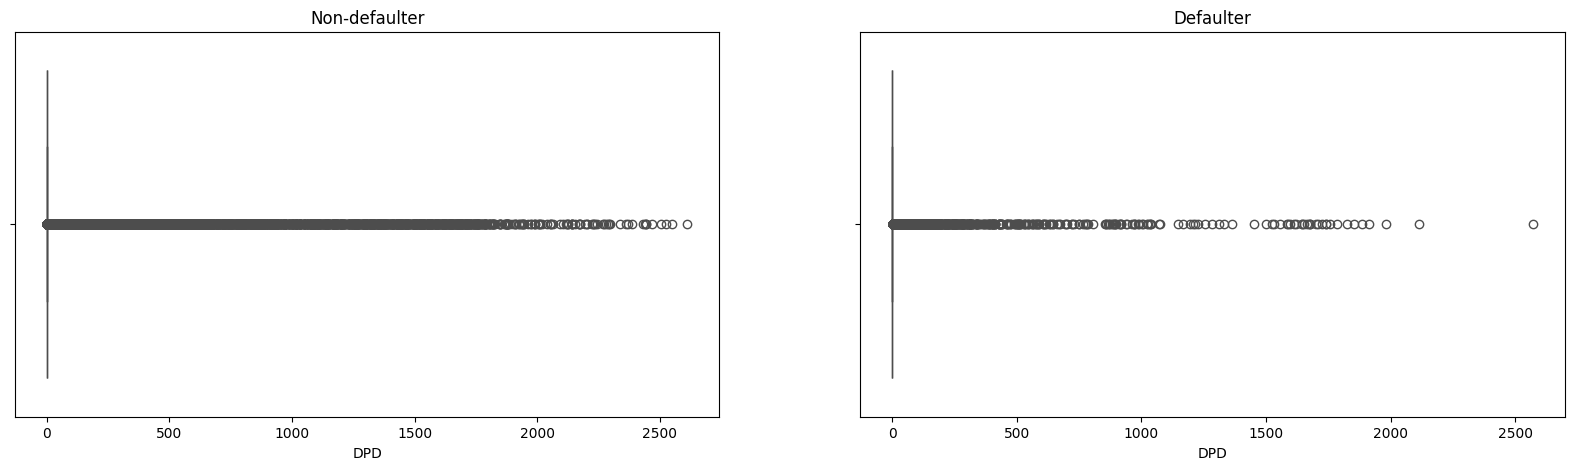

In [11]:
# Trả nợ quá hạn
visualize.box_plot2(x="DPD", df1= pay_non_default, df2=pay_default, width= 20, height=5)

--> Nhóm non-default có mật độ thời gian chậm trả quá hạn (trong khoảng 1 - 1750 ngày) nhiều hơn nhóm default (trong khoảng 0-800 ngày)

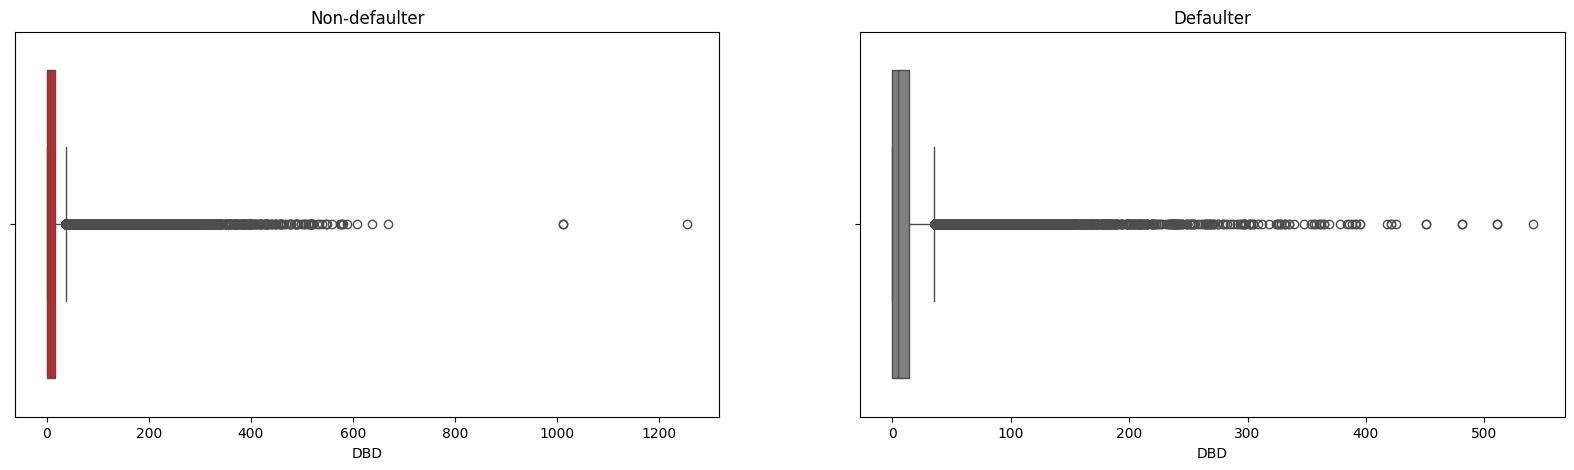

In [12]:
# Trả nợ trước hạn
visualize.box_plot2(x="DBD", df1= pay_non_default, df2=pay_default, width = 20, height=5)

- Dựa trên số liệu thống kê số ngày trả trước hạn, ta thấy khoảng quantile của nhóm default lớn hơn nhóm non-default 
Bên cạnh đó, nhóm non_default có xu hướng trả trước hạn tương đối sớm (50-400) ngày với mật độ lớn hơn nhóm default
--> Nhóm non-default có xu hướng trả nợ trước hạn nhiều hơn nhóm default

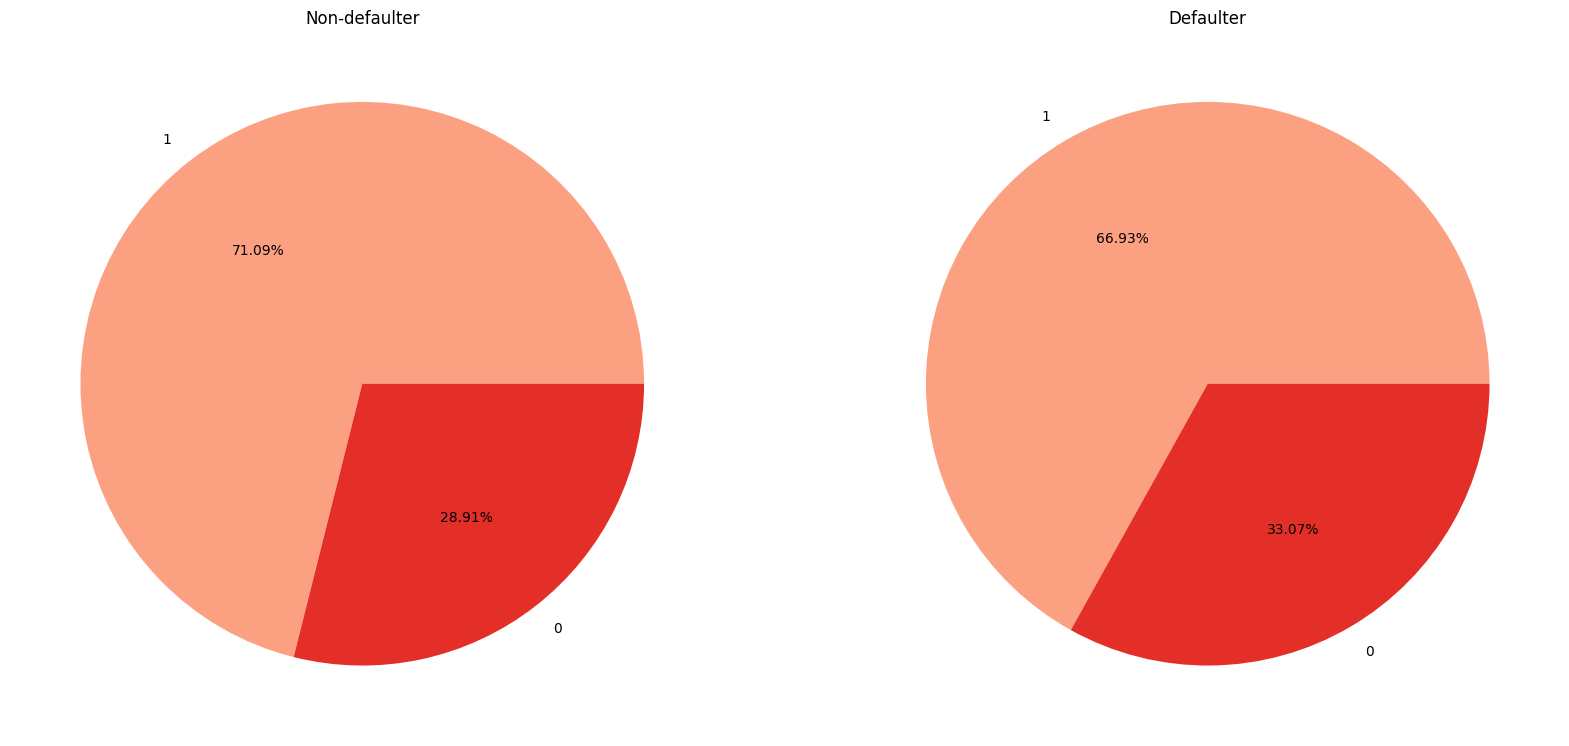

In [13]:
visualize.pie_plot(x='LATE_PAYMENT', df1=pay_non_default, df2=pay_default, width= 20, height=20)

Nhận xét: Tỉ lệ chậm trả ở các nhóm default và non - default không chênh lệch quá nhiều (khoảng ~5%)

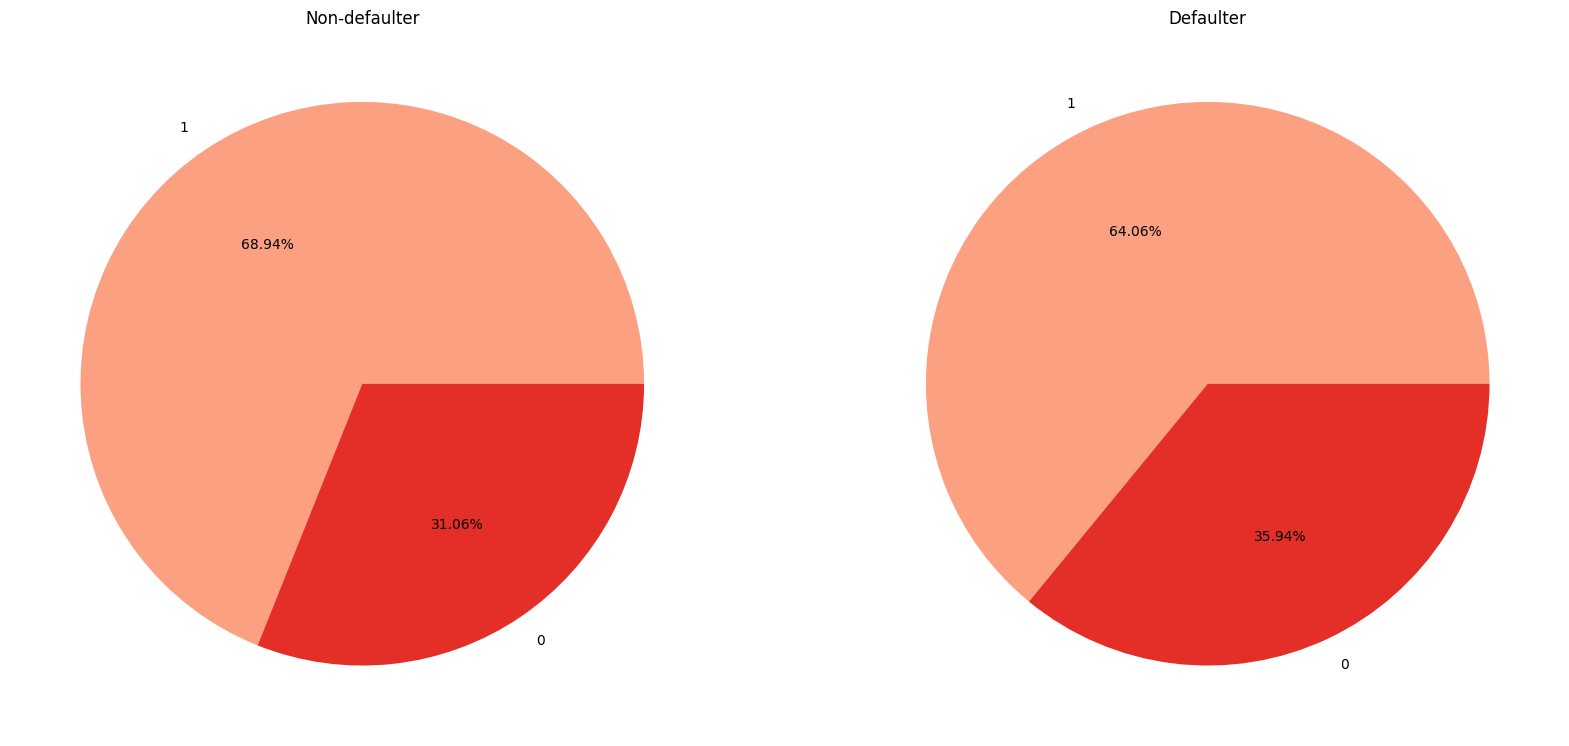

In [14]:
visualize.pie_plot(x='SIGNIFICANT_LATE_PAYMENT', df1=pay_non_default, df2=pay_default, width= 20, height=20)

Nhận xét: Những khoản vay có tỉ lệ trả nợ thực/danh nghĩa < 5% (trả chưa được quá 5% khoản cần trả) chiếm tỉ trọng ở nhóm default cao hơn nhóm non-default 

--> Nhận xét: Căn cứ vào thời gian trả trước, sau hạn:
# Giải thích cho các feature sinh thêm 
- Các khoản vay có thời gian trả trước/sau hạn nhỏ thường là các khoản vay tín dụng (từ thẻ tín dụng)
- Các khoản vay có thời gian trả trước/sau hạn lớn có thể là các khoản vay mua xe, mua nhà, hoặc có mục đích tín dụng lớn (đầu tư dài hạn, mua BĐS)
- Chia nợ ngắn hạn làm 3 nhóm nợ theo thời gian quá hạn (7, 15, 120):
- 7, 15 ngày: cho các khoản vay tín dụng
- 120 ngày: Cho các khoản vay dài hạn Bên cạnh đó, nếu convert từ ngày sang tháng, có thể xem xét chia các khoản vay theo các mốc:
- Ngắn hạn: Dưới 1 năm (12 tháng)
- Trung Hạn: Trên 1 năm và dưới 5 năm (có thể lấy trong khoảng 30-60 tháng)
- Dài hạn: Trên 5 năm


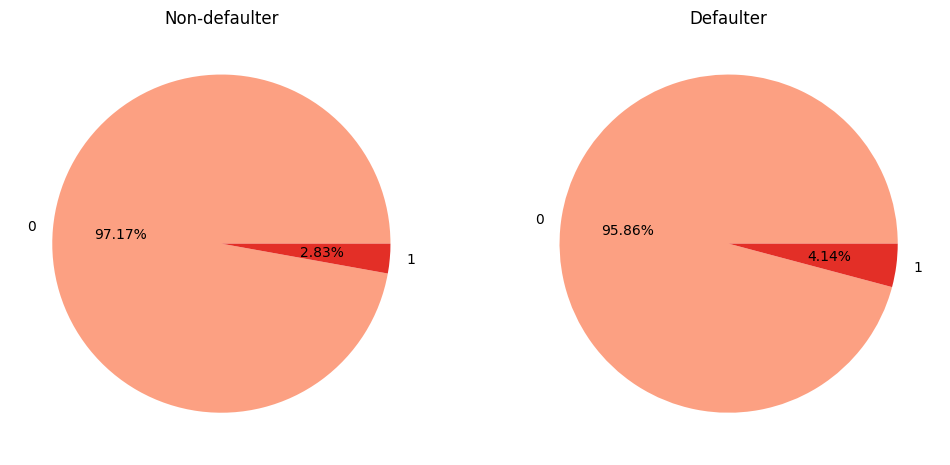

In [15]:
visualize.pie_plot(x='DPD_7', df1= pay_non_default, df2=pay_default)

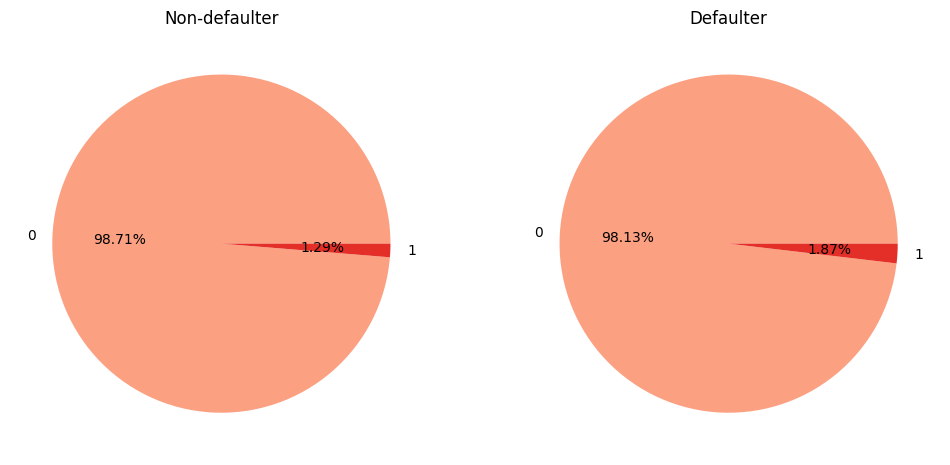

In [16]:
visualize.pie_plot(x='DPD_15', df1= pay_non_default, df2=pay_default)

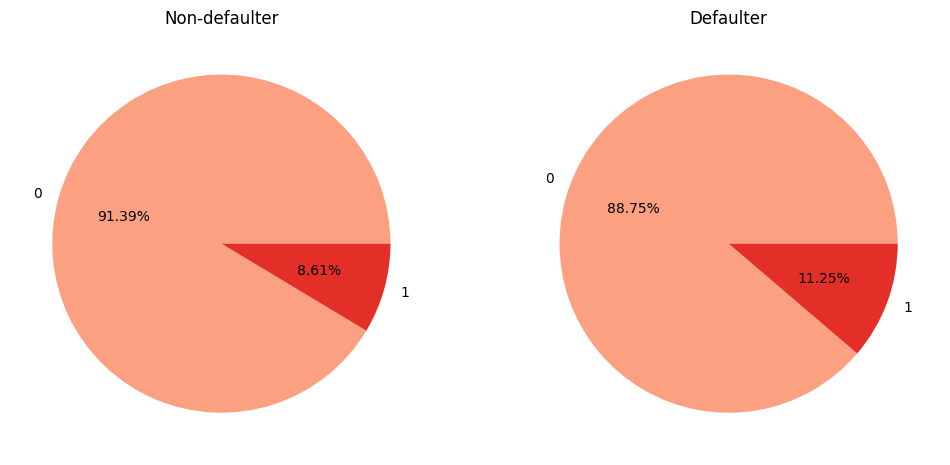

In [17]:
visualize.pie_plot(x='INS_IS_DPD_UNDER_120', df1= pay_non_default, df2=pay_default)